In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

We will be solving the following ordinary differential equation, a damped mass-spring system, with a physics-informed neural network (PINN).
$$
m\ddot{x} + c\dot{x} + kx = 0
$$
where `m`, `c`, and `k` are the mass, damping coefficient, and spring constant, respectively. The initial conditions are `x(0) = 1` and `v(0) = 0`. To make this easier, we will define two constants, the "damping ratio" $\zeta = \frac{c}{2\sqrt{mk}}$ and the "natural frequency" $\omega_n = \sqrt{\frac{k}{m}}$. The equation can then be rewritten as
$$
\ddot{x} + 2\zeta\omega_n\dot{x} + \omega_n^2x = 0
$$

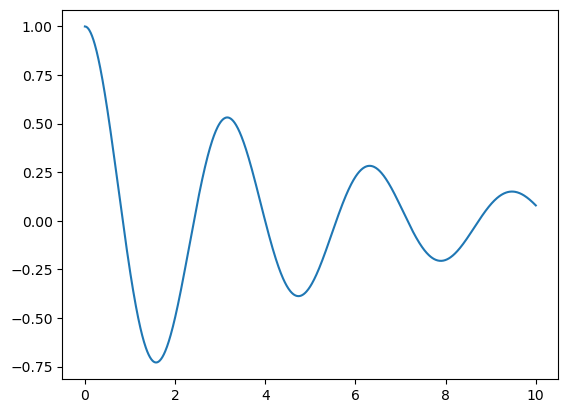

In [21]:
def exact_solution(t, zeta, omega):
    omega_d = omega * np.sqrt(1 - zeta**2)
    x = np.exp(-zeta * omega * t) * (np.cos(omega_d * t) + zeta * omega / omega_d * np.sin(omega_d * t))
    return x

# test plot to make sure the exact solution is correct
t = np.linspace(0, 10, 1000)
zeta = 0.1
omega = 2
x = exact_solution(t, zeta, omega)
plt.plot(t, x)
plt.show()

We will use a PINN, a neural network that is trained to satisfy a differential equation and its initial conditions. We do this by defining our loss functional to have two components, the boundary loss and the physics (or residual) loss. The boundary loss is the mean squared error of the neural network's predictions at the initial conditions, and the physics loss is the mean squared error of the differential equation. The total loss is the sum of the boundary and physics losses. We will use the Adam optimizer to minimize this loss.
$$
\mathcal{L} = \mathcal{L}_{\text{boundary}} + \mathcal{L}_{\text{physics}} = \left(\frac{1}{N_b}\sum_{i=1}^{N_b} \left| x(t_i) - x_i \right|^2 + \left| v(t_i) - v_i \right|^2\right) + \left(\frac{1}{N_p}\sum_{i=1}^{N_p} \left| \ddot{x}(t_i) + 2\zeta\omega_n\dot{x}(t_i) + \omega_n^2x(t_i) \right|^2\right)
$$

In [22]:
class PINN(nn.Module):
    def __init__(self, hidden_dim=20, num_hidden_layers=3):
        super(PINN, self).__init__()
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_dim, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [23]:
def oscillator_residual(model, t, zeta, omega):
    t.requires_grad = True
    x = model(t)

    x_dot = torch.autograd.grad(
        x, t, grad_outputs=torch.ones_like(x), create_graph=True
    )[0]
    x_ddot = torch.autograd.grad(
        x_dot, t, grad_outputs=torch.ones_like(x_dot), create_graph=True
    )[0]

    residual = x_ddot + 2 * zeta * omega * x_dot + omega**2 * x
    return residual

In [24]:
def loss_functional(model, t_coll, t_init, x_init, v_init, zeta, omega):
    res = oscillator_residual(model, t_coll, zeta, omega)
    mse = torch.mean(res**2)

    x_pred_init = model(t_init)
    v_pred_init = torch.autograd.grad(
        x_pred_init, t_init, grad_outputs=torch.ones_like(x_pred_init), create_graph=True
    )[0]
    loss = mse + torch.mean((x_pred_init - x_init)**2) + torch.mean((v_pred_init - v_init)**2)
    return loss

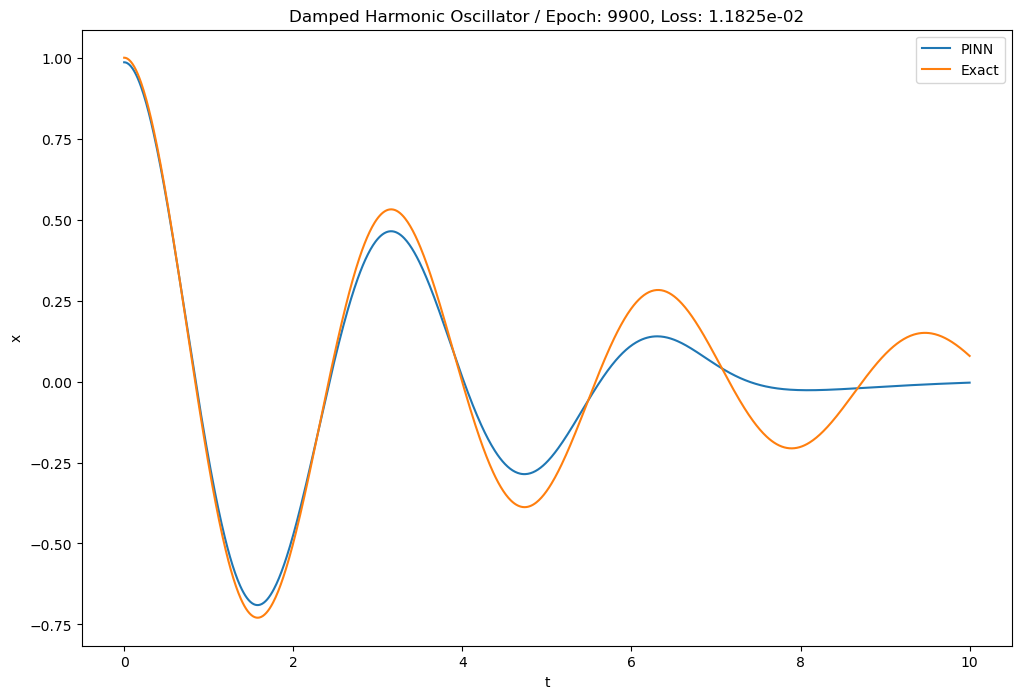

In [25]:
zeta = 0.1
omega = 2

model = PINN()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

t_coll = torch.linspace(0, 10, 1000).view(-1, 1)
t_init = torch.tensor([[0.0]], requires_grad=True)
x_init = torch.tensor([[1.0]])
v_init = torch.tensor([[0.0]])

epochs = 10000
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = loss_functional(model, t_coll, t_init, x_init, v_init, zeta, omega)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        t_test = torch.linspace(0, 10, 1000).view(-1, 1)
        x_pred = model(t_test).detach().numpy()
        t_test_np = t_test.detach().numpy()

        clear_output(wait=True)
        plt.figure(figsize=(12, 8))
        plt.plot(t_test_np, x_pred, label='PINN')
        plt.plot(t_test_np, exact_solution(t_test_np, zeta, omega), label='Exact')
        plt.legend()
        plt.xlabel('t')
        plt.ylabel('x')
        plt.title(f'Damped Harmonic Oscillator / Epoch: {epoch}, Loss: {loss.item():.4e}')
        plt.show()
